In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from gurobipy import Model, GRB, quicksum

In [2]:
relationship_mtx = pd.read_csv('../data/raw/Wedding Guest Network Data - Connection Matrix.csv', index_col=0)
constraint_mtx = pd.read_csv('../data/raw/Wedding Guest Network Data - Seating Constraints.csv', index_col=0)
guest_list_df = pd.read_csv('../data/raw/Wedding Guest Network Data - Guest List.csv', index_col=0)

In [3]:
relationship_mtx.index = ['_'.join(g.split(' ')) for g in relationship_mtx.index]
relationship_mtx.columns = ['_'.join(g.split(' ')) for g in relationship_mtx.columns]

constraint_mtx.index = ['_'.join(g.split(' ')) for g in constraint_mtx.index]
constraint_mtx.columns = ['_'.join(g.split(' ')) for g in constraint_mtx.columns]

In [4]:
constraint_mtx.fillna(0, inplace=True)

In [5]:
all(constraint_mtx.columns == relationship_mtx.columns) and all(constraint_mtx.index == relationship_mtx.index) and all(constraint_mtx.index == constraint_mtx.columns)

True

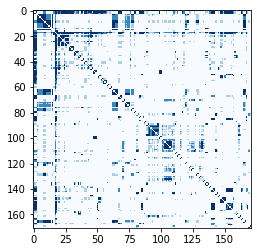

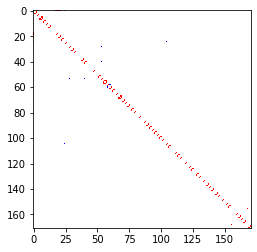

In [6]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15
plt.imshow(relationship_mtx.values, cmap='Blues', interpolation='nearest')
plt.show()

plt.imshow(constraint_mtx.values, cmap='bwr', interpolation='nearest')
plt.show()

In [7]:
guest_list = relationship_mtx.index.values.tolist()

In [8]:
len(guest_list)

171

In [9]:
for g in guest_list:
    for gp in guest_list:
        if gp == g:
            continue

        if relationship_mtx.loc[g, gp] != relationship_mtx.loc[gp, g]:
            print(f"relationship: {g} with {gp} does not match {gp} with {g}")

        if constraint_mtx.loc[g, gp] != constraint_mtx.loc[gp, g]:
            print(f"constraint: {g} with {gp} does not match {gp} with {g}")

In [10]:
guest_list_df.index = guest_list
age_difference_mtx = pd.DataFrame(0, columns=guest_list, index=guest_list)
for g in guest_list:
    for gp in guest_list:
        age_difference_mtx.loc[g, gp] = np.abs(guest_list_df.loc[g, 'age'] - guest_list_df.loc[gp, 'age'])

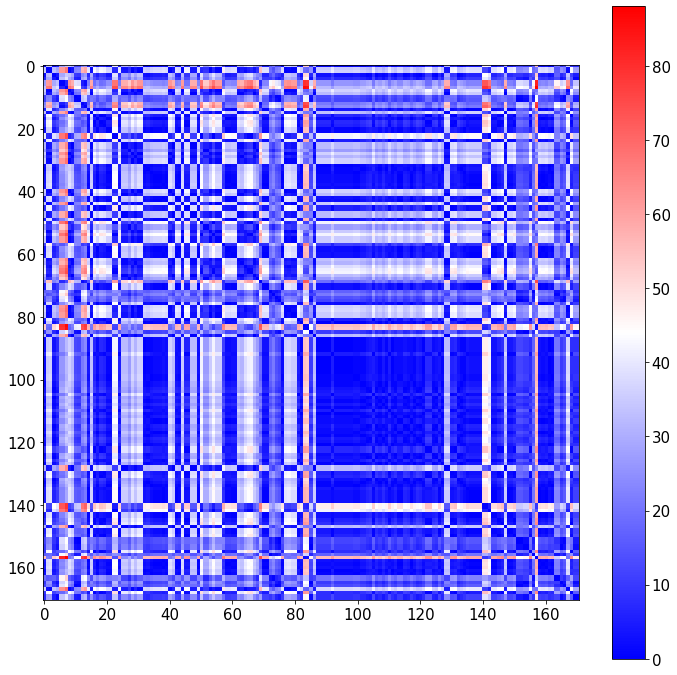

In [11]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15

plt.imshow(age_difference_mtx.values, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.show()

In [12]:
guest_list = np.random.choice(guest_list, size=30, replace=False)

In [13]:
guests_per_table = 8
age_difference_penalty = 0.01
must_sit_together_score = 100

In [14]:
tables = {
    f'Table_{t+1}': guests_per_table for t in range(len(guest_list)//guests_per_table + 1)
}

In [15]:
seating_model = Model()

Restricted license - for non-production use only - expires 2023-10-25


In [16]:
y = seating_model.addVars(guest_list, tables.keys(), vtype=GRB.BINARY, name="y")

In [17]:
not_seated_together_list = []
for i, g in enumerate(guest_list):
    for gp in guest_list[i+1:]:

        if constraint_mtx.loc[g, gp] == 1:
            relationship_mtx.loc[g, gp] *= must_sit_together_score
        elif constraint_mtx.loc[g, gp] == -1:
            not_seated_together_list.append(('_'.join(g.split(' ')), '_'.join(gp.split(' '))))

In [18]:
not_seated_together_list

[]

In [19]:
seating_model.setObjective(
    quicksum(
        quicksum(
            quicksum(
                (-relationship_mtx.loc[g, gp] + age_difference_penalty * (age_difference_mtx.loc[g, gp]) if age_difference_mtx.loc[g, gp] >= 0 else 0) * y[(g, table)] * y[(gp, table)] \
                    for table in tables.keys()) \
                for gp in guest_list[i+1:]) \
            for i, g in tqdm(enumerate(guest_list), total=len(guest_list))
    )
)

100%|██████████| 30/30 [00:00<00:00, 171.70it/s]


In [20]:
seating_model.addConstrs(quicksum(y[(g, table)] for g in guest_list) <= max_seats for table, max_seats in tables.items())

{('Table_1', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('Table_2', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('Table_3', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('Table_4', 8): <gurobi.Constr *Awaiting Model Update*>}

In [21]:
seating_model.addConstrs(y[g, table] + y[gp, table] <= 1 for table in tables.keys() for g, gp in not_seated_together_list)

{}

In [22]:
seating_model.addConstrs(quicksum(y[g, table] for table in tables.keys()) == 1 for g in guest_list)

{'Jimmy_Harvey': <gurobi.Constr *Awaiting Model Update*>,
 'Claire_Meunier': <gurobi.Constr *Awaiting Model Update*>,
 'Trish_Davis': <gurobi.Constr *Awaiting Model Update*>,
 'Mallory_Chandler': <gurobi.Constr *Awaiting Model Update*>,
 'Chris_Donlon': <gurobi.Constr *Awaiting Model Update*>,
 'Angelo_Morales': <gurobi.Constr *Awaiting Model Update*>,
 'Mary_Campen': <gurobi.Constr *Awaiting Model Update*>,
 'Rick_Strauss': <gurobi.Constr *Awaiting Model Update*>,
 'Wendy_Bell': <gurobi.Constr *Awaiting Model Update*>,
 'Cameron_Berkowitz': <gurobi.Constr *Awaiting Model Update*>,
 'Danielle_Harvey': <gurobi.Constr *Awaiting Model Update*>,
 'Nick_Baltaxe': <gurobi.Constr *Awaiting Model Update*>,
 'Suzie_Campen': <gurobi.Constr *Awaiting Model Update*>,
 'Aaron_Hoogstraten': <gurobi.Constr *Awaiting Model Update*>,
 'Debbie_Roper': <gurobi.Constr *Awaiting Model Update*>,
 'Bonnie_Neel': <gurobi.Constr *Awaiting Model Update*>,
 'Jukka_Aromaa': <gurobi.Constr *Awaiting Model Update*>

In [23]:
seating_model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 34 rows, 120 columns and 240 nonzeros
Model fingerprint: 0xc4593493
Model has 1684 quadratic objective terms
Variable types: 0 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 4.4000000
Presolve time: 0.00s
Presolved: 1718 rows, 1804 columns, 5292 nonzeros
Variable types: 0 continuous, 1804 integer (1804 binary)

Root relaxation: objective -6.782200e+02, 269 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -678.22000    0   74    4.40000 -678.22000      -    

In [24]:
solution = {t: [] for t in tables.keys()}
for var in seating_model.getVars():
    if var.X == 1.0:
        guest, table = var.VarName.split('[')[1].split(']')[0].split(',')
        solution[table].append(' '.join(guest.split('_')))

In [25]:
solution

{'Table_1': ['Trish Davis',
  'Wendy Bell',
  'Debbie Roper',
  'Bonnie Neel',
  'Jukka Aromaa',
  'Sean Neel',
  'Gail Olson',
  'Gordon Carey'],
 'Table_2': ['Mary Campen',
  'Rick Strauss',
  'Suzie Campen',
  'Mac Pattison',
  'Jack Gretta',
  'Morgan Pattison'],
 'Table_3': ['Claire Meunier',
  'Mallory Chandler',
  'Cameron Berkowitz',
  'Nick Baltaxe',
  'Aaron Hoogstraten',
  'Andres Cifuentes',
  'Genevieve Geoghan',
  'Hunter Sullivan'],
 'Table_4': ['Jimmy Harvey',
  'Chris Donlon',
  'Angelo Morales',
  'Danielle Harvey',
  'Megan Kesselman',
  'Natalie Kanshanchi',
  'Savannah Rivers',
  'Cody Vild']}

In [23]:
seating_model.write('../models/seating_model.mps')